In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import matplotlib.pyplot as plt
import torch 
import numpy as np
from infopath.utils.functions import load_data, opto, run_with_perturbation, pear_corr, feature_pop_avg, mse_2d
from infopath.losses import noise_cross_corr, cross_corr_guillaume, cross_corr_jitter, reorder_model_trials
from infopath.train import t_trial_pearson
import scipy.sparse as sp
from infopath.config import compare_opt
from scipy.optimize import linear_sum_assignment
import os
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis

%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42

trials = 200
thr = 7

In [2]:
os.chdir("..")

In [3]:
logs = {
    "nofb": 
    [
        "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf_block",
        
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_2_14_49_6_l1across200_seed0",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_2_14_49_8_l1across200_seed1",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_2_14_49_9_l1across200_seed2",

        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_4_12_45_32_l1across0_seed0",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_4_12_46_42_l1across0_seed1",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_4_12_46_42_l1across0_seed2",
        
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_24_11_38_32_l1across100_seed0",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_24_11_38_32_l1across100_seed1",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_29_16_10_31_l1across100_seed2",

        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_24_11_38_12_l1across0_seed0",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_24_11_38_16_l1across0_seed1",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_29_16_10_30_l1across0_seed2",
        ],
    "withfb1":
    [
        "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf",
        
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_5_16_2_9_l1across10_seed0",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_5_16_2_7_l1across10_seed1",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_5_16_2_9_l1across10_seed2",

        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_4_12_46_46_l1across0_seed0",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_4_12_46_43_l1across0_seed1",
        "log_dir/1bde1ac87d7cb15dc373cf094c2db105bed98319/2024_6_4_12_46_50_l1across0_seed2",
        
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_25_9_26_38_l1across10_seed0",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_25_9_26_33_l1across10_seed1",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_29_18_7_58_l1across10_seed2",

        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_25_9_26_31_l1across0_seed0",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_25_9_26_34_l1across0_seed1",
        "log_dir/39a37b302593931ad8f1977c82e16327590f2805/2024_6_29_17_22_27_l1across0_seed2",
        ]
}

In [4]:
def give_name(opt):
    if opt.loss_cross_corr:
        if not opt.l1_decay_across > 0:
            return "No sparsity + Cross-corr."
        return "Full rec. method + Cross-corr."
    if not opt.l1_decay_across > 0:
        return "No sparsity"
    return "Full rec. method"

In [5]:
def pear_corr(y, y_pred, eps=1e-8, dim=1):
    y, y_pred = y.cpu().numpy(), y_pred.cpu().numpy()
    if dim == 1:
        y_pred = (y_pred.T - y.mean(dim)).T
        y = (y.T - y.mean(dim)).T
    else:
        y_pred = y_pred - y.mean(dim)
        y = y - y.mean(dim)
    cov = (y * y_pred).sum(dim)
    y_sqr = (y * y).sum(dim)
    y_sqr_pred = (y_pred * y_pred).sum(dim)
    # x = cov / ((y_sqr * y_sqr_pred) ** 0.5 + eps)
    return cov / ((y_sqr * y_sqr_pred) ** 0.5 + eps)


def trial_matched_pearson(model, idx, spikes_nofb, spikes):   
    t_trial_nofb, t_trial = feature_pop_avg(
        model.filter_fun2(model.filter_fun1(spikes_nofb[:, :, idx])),
        model.filter_fun2(model.filter_fun1(spikes[:, :, idx])),
        None,
        None,
        model.rsnn.area_index[idx],
        model.rsnn.excitatory_index[idx],
        0,
        z_score=model.opt.z_score,
    )

    t_trial_nofb, t_trial = t_trial_nofb.T, t_trial.T
    keep = min(t_trial_nofb.shape[1], t_trial.shape[1])
    keep_train = torch.randperm(t_trial_nofb.shape[1])[:keep]
    keep_test = torch.randperm(t_trial.shape[1])[:keep]
    t_trial_nofb, t_trial = t_trial_nofb[:, keep_train], t_trial[:, keep_test]
    cost = mse_2d(t_trial_nofb, t_trial)
    keepx, ytox = linear_sum_assignment(cost.detach().cpu().numpy())
    t_trial_nofb = t_trial_nofb[:, keepx]
    t_trial = t_trial[:, ytox]
    return pear_corr(t_trial.T, t_trial_nofb.T), t_trial_nofb, t_trial, torch.nn.MSELoss()(t_trial_nofb, t_trial).item()

# 95% confidence interval of bernoulli variable
def confidence_interval(p, n):
    return 1.96 * np.sqrt(p * (1-p) / n)
confidence_interval(0.55, 2000)


0.02180362355206125

datasets/GoNoGo_nofb
Full rec. method 0.02867657
datasets/GoNoGo_nofb
No sparsity 0.32585314
datasets/GoNoGo_nofb_seed2
Full rec. method + Cross-corr. 0.05212754
datasets/GoNoGo_nofb_seed2


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


No sparsity + Cross-corr. 0.23023498


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


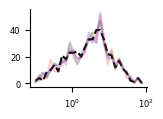

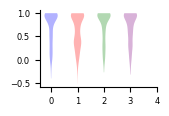

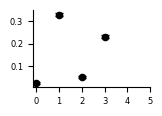

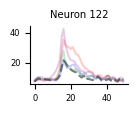

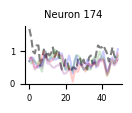

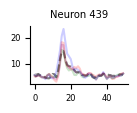

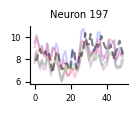

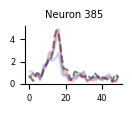

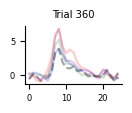

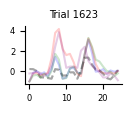

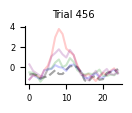

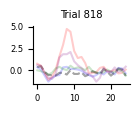

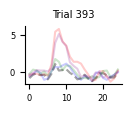

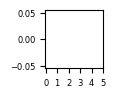

In [6]:
trials = 2000
colors = {"base":"black", "teachers":"black", "No sparsity": "red", "Full rec. method": "blue", "Full rec. method + Cross-corr.": "green", "No sparsity + Cross-corr.": "purple"}
area = 1
exc = 1
power = 0.08
hypothesis = "nofb"
thr = 7

table_psth_pear_mean_nofb, table_psth_pear_std_nofb = [], []
hit_miss_mean, hit_miss_std = [], []
phi, phi_std = [], []
bins = np.linspace(-1, 2, 30)
opt = load_training_opt(logs[hypothesis][0])
model_nofb = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
_, trial_type_nofb, _, spikes_nofb = run_with_perturbation(model_nofb, trials=trials, area=area, exc=exc, power=power, seed=0, thr=thr)
_, _, _, spikes_nofb_seed1 = run_with_perturbation(model_nofb, trials=trials, area=area, exc=exc, power=power, seed=3, thr=thr)

fr_nofb = spikes_nofb[:50].mean((0,1)) / model_nofb.timestep
psth_nofb = model_nofb.filter_fun1(spikes_nofb).mean(1) / model_nofb.timestep
trial_type_perc = trial_type_nofb.unique(return_counts=True)[1].cpu()
# hit_miss_mean.append(trial_type_perc[3] / (trial_type_perc[0] + trial_type_perc[3]))
fig, ax = plot_with_size(30, 20)
x, y = np.histogram(fr_nofb.cpu().numpy().flatten(), bins=10**bins)
ax.plot(y[:-1], x, color="black", linestyle="--")
ax.set_xscale("log")
# violin = ax.violinplot([fr_nofb[fr_nofb > 0].cpu().numpy().flatten()], positions=[0], showextrema=False)#bins=10**bins, color="black", alpha=0.2, label="Teacher")
# violin["bodies"][0].set_facecolor("black")
fig_psth, ax_psth = plot_with_size(30, 20)
fig_ttrial, ax_ttrial = plot_with_size(30, 20)
torch.manual_seed(2)
np.random.seed(4)
random_neurons = np.random.choice(500, 5)
figs_psth_single, axs_psth_single = [], []
for n in random_neurons:
    fig_psth_single, ax_psth_single = plot_with_size(25, 15)
    strip_right_top_axis(ax_psth_single)
    figs_psth_single.append(fig_psth_single)
    axs_psth_single.append(ax_psth_single)
    axs_psth_single[-1].plot(psth_nofb[:, n].cpu().numpy(), color="black", alpha=0.5, linestyle="--")

random_trials = np.random.choice(trials, 5)
figs_trial_single, axs_trial_single = [], []
for n in random_trials:
    fig_trial_single, ax_trial_single = plot_with_size(25, 15)
    strip_right_top_axis(ax_trial_single)
    figs_trial_single.append(fig_trial_single)
    axs_trial_single.append(ax_trial_single)

idx = model_nofb.rsnn.area_index == abs(1-area)
if power == 0:
    idx = model_nofb.rsnn.area_index > -1  
rho_rc = trial_matched_pearson(model_nofb, idx, spikes_nofb, spikes_nofb_seed1)[0]

# ax.hist(fr.cpu().numpy().flatten(), bins=10**bins, alpha=0.2, color="black")
# ax.set_xscale("log")
mse = []
for i, log in enumerate(logs[hypothesis][1::3]):#[1::3]):
    opt = load_training_opt(log)
    model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
    print(opt.datapath)
    name = give_name(opt)
    _, trial_type, _, spikes = run_with_perturbation(model, trials=trials, area=area, exc=exc, power=power, seed=1, thr=thr)
    trial_type_perc = trial_type.unique(return_counts=True)[1].cpu()
    # hit_miss_mean.append(trial_type_perc[3] /  (trial_type_perc[0] + trial_type_perc[3]))
    fr = spikes[:50].mean((0,1)) / model.timestep 
    psth = model.filter_fun1(spikes).mean(1) / model.timestep
    t_neuron = pear_corr(psth, psth_nofb, dim=0) # pear_corr(psth, psth_nofb)
    # t_neuron = (1 - ((psth - psth_nofb)**2).mean(0) / ((psth_nofb - psth_nofb.mean(0))**2).mean(0)).cpu().numpy()
    t_neuron = t_neuron[fr_nofb.cpu().numpy() > 0]
    table_psth_pear_mean_nofb.append(t_neuron.mean())
    table_psth_pear_std_nofb.append(t_neuron.std())
    violin = ax_psth.violinplot([t_neuron], positions=[i], showextrema=False)
    violin["bodies"][0].set_facecolor(colors[name])
    # ax_psth.set_ylim(0, 1)
    ax_psth.set_xticks(range(5))
    # ax.hist(fr.cpu().numpy().flatten(), bins=10**bins, alpha=0.2, color=colors[name])
    # ax.set_xscale("log")
    x, y = np.histogram(fr[fr > 0].cpu().numpy().flatten(), bins=10**bins)
    ax.plot(y[:-1], x, color=colors[name], alpha=0.2)
    # violin = ax.violinplot([fr[fr > 0].cpu().numpy().flatten()], positions=[i+1], showextrema=False)#bins=10**bins, color="black", alpha=0.2, label="Teacher")
    # violin["bodies"][0].set_facecolor(colors[name])
    # ax.set_xticks(range(6))
    # ax.set_ylim(0.01, 10)


    for j, n in enumerate(random_neurons):
        axs_psth_single[j].plot(psth[:, n].cpu().numpy(), color=colors[name], alpha=0.2)
        axs_psth_single[j].set_title(f"Neuron {n}")
    rho_rn, t_trial_nofb, t_trial, mse1 = trial_matched_pearson(model, idx, spikes_nofb, spikes)
    mse.append(mse1)
    phi.append(rho_rc.mean() - rho_rn.mean())
    phi_std.append(((rho_rn.std())**2 + (rho_rc.std())**2)**0.5/np.sqrt(trials))
    print(name, phi[-1]) 

    for j, n in enumerate(random_trials):
        axs_trial_single[j].plot(t_trial_nofb[:, n].cpu().numpy(), color="black", alpha=0.1, linestyle="--")
        axs_trial_single[j].plot(t_trial[:, n].cpu().numpy(), color=colors[name], alpha=0.2)
        axs_trial_single[j].set_title(f"Trial {n}")


xs = np.arange(len(phi))
ax_ttrial.scatter(xs, phi, color="black", s=20)
ax_ttrial.errorbar(xs, phi, yerr=phi_std, fmt="none", capsize=3, color="black")
ax_ttrial.set_xticks(range(6))

strip_right_top_axis(ax)
strip_right_top_axis(ax_psth)
strip_right_top_axis(ax_ttrial)
fig.savefig(f"FiguresOpto/Supplementary_Figure1/fr_{hypothesis}.pdf", bbox_inches="tight", transparent=True)
fig_psth.savefig(f"FiguresOpto/Supplementary_Figure1/psth_{hypothesis}.pdf", bbox_inches="tight", transparent=True)
fig_ttrial.savefig(f"FiguresOpto/Supplementary_Figure1/ttrial_{hypothesis}.pdf", bbox_inches="tight", transparent=True)
for i, fig in enumerate(figs_psth_single):
    fig.savefig(f"FiguresOpto/Supplementary_Figure1/psth_single_{hypothesis}_{i}.pdf", bbox_inches="tight", transparent=True)
for i, fig in enumerate(figs_trial_single):
    fig.savefig(f"FiguresOpto/Supplementary_Figure1/trial_single_{hypothesis}_{i}.pdf", bbox_inches="tight", transparent=True)


fig, ax = plot_with_size(15, 15)
xs = np.arange(len(hit_miss_mean))
ax.scatter(xs, hit_miss_mean, color="black", s=20)
ax.errorbar(xs, hit_miss_mean, yerr=confidence_interval(np.array(hit_miss_mean), 2000), fmt="none", capsize=3, color="black")
ax.set_xticks(range(6))

fig.savefig(f"FiguresOpto/Supplementary_Figure1/hit_miss_{hypothesis}.pdf", bbox_inches="tight", transparent=True)

In [6]:
import pandas as pd
area = 1
trials = 2000
for hypothesis in ["withfb1", "nofb"]:
    models = []
    for log in logs[hypothesis]:
        opt = load_training_opt(log)
        model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
        models.append(model)
    print('hello')
    for activation in [0, 1]:
        df = pd.DataFrame(columns=("hypothesis", "model_name", "phi21", "power", "activation", "seed"))
        if activation == 1:
            power = [0, 0.01, 0.02, 0.04, 0.08]
        else:
            power = [0, 0.1, 0.2 ,0.5, 1]
        for p in power:
            _, trial_type_nofb, _, spikes_nofb = run_with_perturbation(models[0], trials=trials, area=area, exc=activation, power=p, seed=0, thr=thr)
            _, _, _, spikes_nofb_seed1 = run_with_perturbation(models[0], trials=trials, area=area, exc=activation, power=p, seed=3, thr=thr)
            idx = models[0].rsnn.area_index == abs(1-area)
            rho_rc = t_trial_pearson(models[0].filter_fun1(spikes_nofb), models[0].filter_fun1(spikes_nofb_seed1),None,None, models[0], [[idx]])
            torch.cuda.empty_cache()
            for i, model in enumerate(models[1:]):
                # opt = load_training_opt(log)
                # model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
                name = give_name(model.opt)
                _, trial_type, _, spikes = run_with_perturbation(model, trials=trials, area=area, exc=activation, power=p, seed=1, thr=thr)
                rho_rn = t_trial_pearson(models[0].filter_fun1(spikes_nofb), models[0].filter_fun1(spikes),None,None, models[0], [[idx]])
                phi = (rho_rc.mean() - rho_rn.mean())
                print(name, phi)
                seed = int(log[-1])
                phi_std = (((rho_rn.std())**2 + (rho_rc.std())**2)**0.5/np.sqrt(trials))
                entry = {"hypothesis": hypothesis, "model_name": name, "phi21": phi, "power": p, "activation": activation, "seed": seed}
                df = pd.concat([df, pd.DataFrame(entry, index=[0])], ignore_index=True)
        act = "activation" if activation else "inactivation"
        df.to_csv(f"FiguresOpto/Supplementary_Figure4/phi_{hypothesis}_{act}.csv")

hello
Full rec. method -0.0035928488
Full rec. method -0.0037133098
Full rec. method -0.0047169924
No sparsity -0.002262354
No sparsity -0.0027270913
No sparsity -0.0035222769
Full rec. method + Cross-corr. 0.0053294897
Full rec. method + Cross-corr. 0.0028301477
Full rec. method + Cross-corr. 0.004254043
No sparsity + Cross-corr. 0.0027065873
No sparsity + Cross-corr. 0.003740549
No sparsity + Cross-corr. 0.0045517683
Full rec. method -0.003027916
Full rec. method -0.0015752912
Full rec. method -0.00352633
No sparsity -0.0018413663
No sparsity -0.0032847524
No sparsity -0.0021915436
Full rec. method + Cross-corr. 0.018887103
Full rec. method + Cross-corr. 0.01374197
Full rec. method + Cross-corr. 0.019109726
No sparsity + Cross-corr. 0.020415545
No sparsity + Cross-corr. 0.017089307
No sparsity + Cross-corr. 0.019245267
Full rec. method -0.0014756322
Full rec. method -0.0005105138
Full rec. method -0.0025154352
No sparsity -0.0007210374
No sparsity -0.0019766688
No sparsity -0.0024331

Full rec. method
No sparsity
Full rec. method + Cross-corr.
No sparsity + Cross-corr.
Full rec. method
No sparsity
Full rec. method + Cross-corr.
No sparsity + Cross-corr.
Full rec. method
No sparsity
Full rec. method + Cross-corr.
No sparsity + Cross-corr.
Full rec. method
No sparsity
Full rec. method + Cross-corr.
No sparsity + Cross-corr.


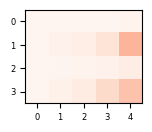

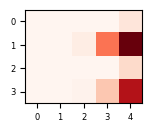

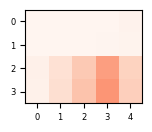

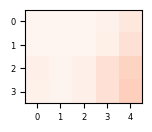

In [8]:
hypothesis = "nofb"
plot_diff = True
colors = {"No sparsity": "red", "Full rec. method": "blue", "Full rec. method + Cross-corr.": "green", "No sparsity + Cross-corr.": "purple"}
label_models = ["Full rec. method", "No sparsity", "Full rec. method + Cross-corr.", "No sparsity + Cross-corr."]

for hypothesis in ["nofb", "withfb1"]:
    for activation in [0, 1]:
        act = "activation" if activation else "inactivation"
        df = pd.read_csv(f"FiguresOpto/Supplementary_Figure4/phi_{hypothesis}_{act}.csv")
        fig1, ax1 = plot_with_size(30, 30)
        if activation == 1:
            powers = [0, 0.01, 0.02, 0.04, 0.08]
        else:
            powers = [0, 0.1, 0.2 ,0.5, 1]
        phis_21 = []
        for name in label_models:
            print(name)
            phi_21 = df[(df.model_name == name) & (df.activation == activation)].groupby("power").phi21.mean().values
            phis_21.append(phi_21)
        phis_21 = np.array(phis_21)
        vmax, vmin = 0.15, 0
        im = ax1.imshow(phis_21, cmap="Reds", vmin=vmin, vmax=vmax)
        yticks = 4
        ax1.set_xticks(range(5))
        # ax1.set_xticklabels(powers)
        ax1.set_yticks(range(4))
        # ax1.set_yticklabels(label_models)
        fig1.savefig(f"FiguresOpto/Supplementary_Figure4/phi_{hypothesis}_{act}.pdf", bbox_inches="tight", transparent=True)

In [18]:
phis_21

array([[-0.00043571],
       [ 0.00354564],
       [-0.00189215],
       [-0.00026238]])